In [1]:


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip marker_detection_dataset.zip marker_detection_dataset

In [2]:
import cv2
import numpy as np
import os
import random
import zipfile
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

In [3]:
IMAGE_SIZE = ( 224, 224 )
BATCH_SIZE = 32
num_epochs = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class MarkerDataset( Dataset ):

  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]

    # Convert from BGR to RGB (OpenCV reads in BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)

    if self.transform:
      image = self.transform(image)

    return image, label

In [5]:
def load_dataset(dataset_path):

  images = [];  labels = []

  # Load Class 0 (No marker)
  class0_path = os.path.join(dataset_path, "0")
  for img_name in os.listdir(class0_path):
    img_path = os.path.join(class0_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
      img = cv2.resize(img, IMAGE_SIZE)
      images.append(img)
      labels.append(0)

  # Load Class 1 (With marker)
  class1_path = os.path.join(dataset_path, "1")
  for img_name in os.listdir(class1_path):
    img_path = os.path.join(class1_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
      img = cv2.resize(img, IMAGE_SIZE)
      images.append(img)
      labels.append(1)

  return np.array(images), np.array(labels)

def create_data_loaders(images, labels):

  train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMAGE_SIZE[0], scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  # Split data into train, validation, and test sets
  x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2,  random_state=42, stratify=labels)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2,  random_state=42, stratify=y_train)

  # Create datasets
  train_dataset = MarkerDataset(x_train, y_train, transform=train_transform)
  val_dataset = MarkerDataset(x_val, y_val, transform=test_transform)
  test_dataset = MarkerDataset(x_test, y_test, transform=test_transform)

  # Create data loaders
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  return train_loader, val_loader, test_loader, (x_test, y_test)

In [6]:
class MarkerDetectionModel(nn.Module):

  def __init__(self, fine_tune=True):
    super(MarkerDetectionModel, self).__init__()

    # MobileNetV2 as the base model
    self.base_model = models.mobilenet_v2(pretrained=True)

    # Freezing base layers
    for param in self.base_model.parameters():
      param.requires_grad = False

    if fine_tune:
      layers_to_unfreeze = 20
      for param in list(self.base_model.parameters())[-layers_to_unfreeze:]:
        param.requires_grad = True

    # Replace the classifier
    num_ftrs = self.base_model.classifier[1].in_features
    self.base_model.classifier = nn.Sequential(
      nn.Dropout(0.2),
      nn.Linear(num_ftrs, 128),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.base_model(x)

In [7]:
DATASET_PATH = "/content/drive/MyDrive/final_dataset(1)(2)/marker_detection_dataset"

# loading dataset
images, labels = load_dataset(DATASET_PATH)
train_loader, val_loader, test_loader, (x_test, y_test) = create_data_loaders(images, labels)


model = MarkerDetectionModel(fine_tune=True)

# loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=M

In [8]:
model = model.to(DEVICE)
history = { 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [] }

for epoch in range( num_epochs ):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  print(f'Epoch {epoch+1}/{num_epochs}')
  for inputs, labels in tqdm(train_loader):
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE).float().unsqueeze(1)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Statistics
    running_loss += loss.item() * inputs.size(0)
    predicted = (outputs >= 0.5).float()
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

# Validation phase
model.eval()
val_running_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():
  for inputs, labels in val_loader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE).float().unsqueeze(1)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Statistics
    val_running_loss += loss.item() * inputs.size(0)
    predicted = (outputs >= 0.5).float()
    val_total += labels.size(0)
    val_correct += (predicted == labels).sum().item()

val_epoch_loss = val_running_loss / len(val_loader.dataset)
val_epoch_acc = val_correct / val_total
history['val_loss'].append(val_epoch_loss)
history['val_acc'].append(val_epoch_acc)

# Step the learning rate scheduler
scheduler.step(val_epoch_loss)
print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\nVal Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

torch.save(model.state_dict(), 'marker_detection_model.pth')

Epoch 1/20


100%|██████████| 232/232 [00:23<00:00,  9.67it/s]


Epoch 2/20


100%|██████████| 232/232 [00:23<00:00, 10.04it/s]


Epoch 3/20


100%|██████████| 232/232 [00:21<00:00, 10.81it/s]


Epoch 4/20


100%|██████████| 232/232 [00:23<00:00,  9.91it/s]


Epoch 5/20


100%|██████████| 232/232 [00:21<00:00, 10.65it/s]


Epoch 6/20


100%|██████████| 232/232 [00:22<00:00, 10.29it/s]


Epoch 7/20


100%|██████████| 232/232 [00:22<00:00, 10.15it/s]


Epoch 8/20


100%|██████████| 232/232 [00:21<00:00, 10.58it/s]


Epoch 9/20


100%|██████████| 232/232 [00:23<00:00,  9.99it/s]


Epoch 10/20


100%|██████████| 232/232 [00:21<00:00, 10.90it/s]


Epoch 11/20


100%|██████████| 232/232 [00:22<00:00, 10.17it/s]


Epoch 12/20


100%|██████████| 232/232 [00:21<00:00, 10.68it/s]


Epoch 13/20


100%|██████████| 232/232 [00:22<00:00, 10.45it/s]


Epoch 14/20


100%|██████████| 232/232 [00:22<00:00, 10.31it/s]


Epoch 15/20


100%|██████████| 232/232 [00:21<00:00, 10.62it/s]


Epoch 16/20


100%|██████████| 232/232 [00:22<00:00, 10.15it/s]


Epoch 17/20


100%|██████████| 232/232 [00:21<00:00, 10.87it/s]


Epoch 18/20


100%|██████████| 232/232 [00:22<00:00, 10.23it/s]


Epoch 19/20


100%|██████████| 232/232 [00:21<00:00, 10.79it/s]


Epoch 20/20


100%|██████████| 232/232 [00:22<00:00, 10.35it/s]


Train Loss: 0.0240 Acc: 0.9939
Val Loss: 0.0029 Acc: 0.9995


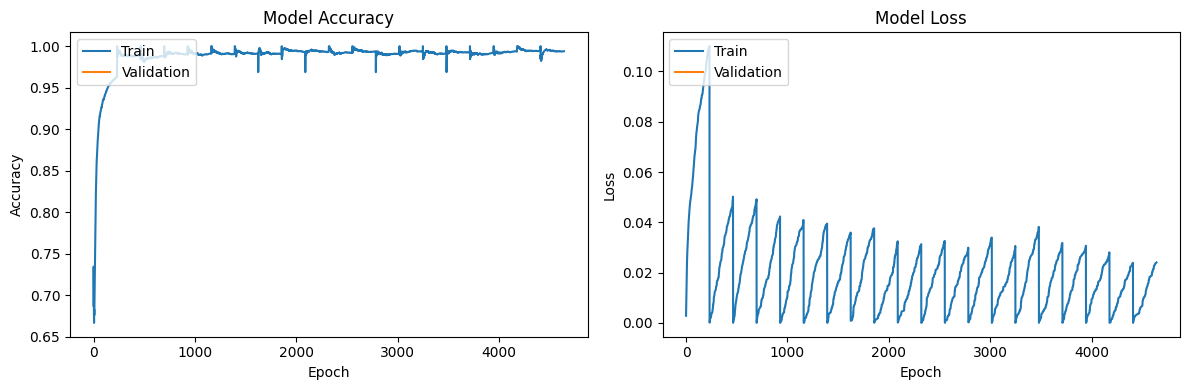

Evaluating model...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 0.5780


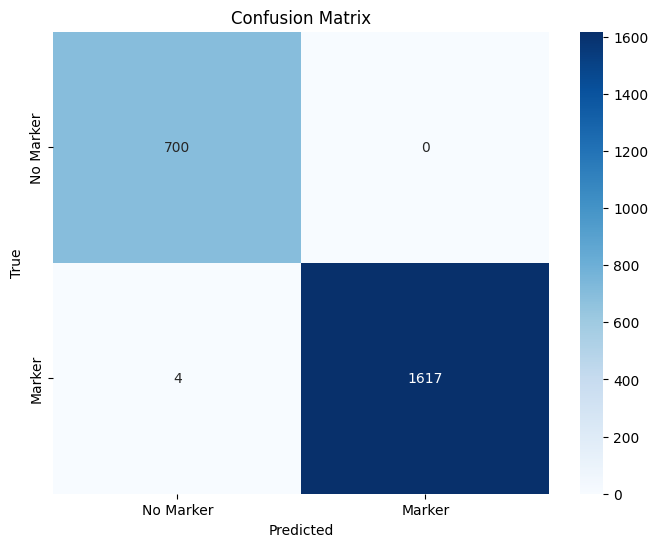


Classification Report:
              precision    recall  f1-score   support

   No Marker       0.99      1.00      1.00       700
      Marker       1.00      1.00      1.00      1621

    accuracy                           1.00      2321
   macro avg       1.00      1.00      1.00      2321
weighted avg       1.00      1.00      1.00      2321



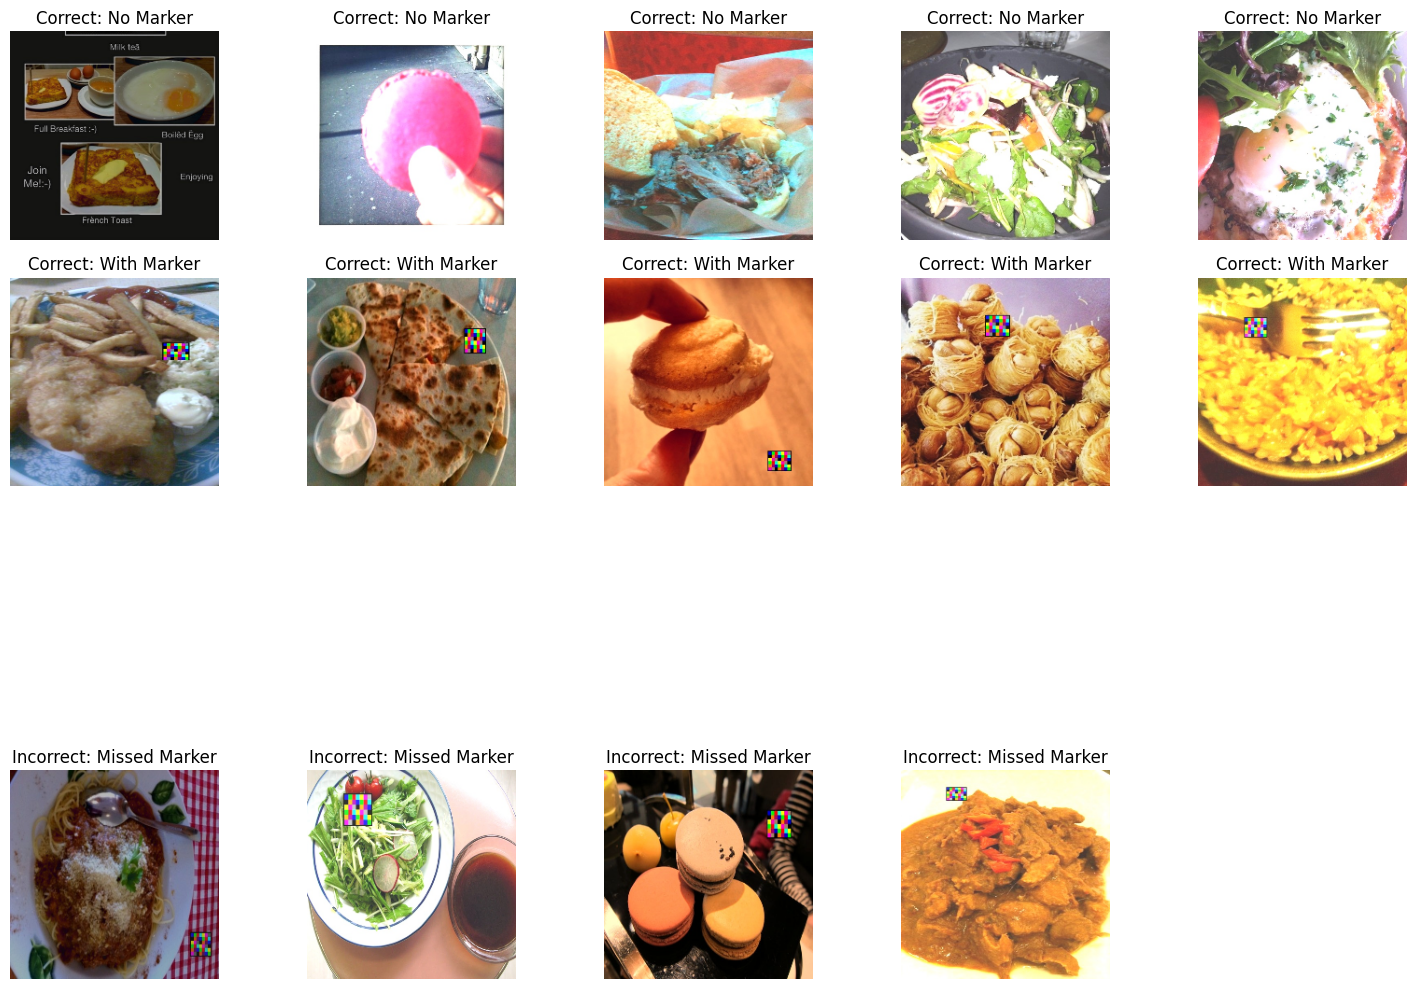

In [13]:
# THIS IS NOW COMPLETE

def plot_training_history(history):
    """Plot training & validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, x_test, y_test):
    """Evaluate the model on the test set and display metrics."""
    model = model.to(DEVICE)
    model.eval()

    # Collect all predictions and true labels
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            probs = outputs.cpu().numpy()
            preds = (probs >= 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # Convert to numpy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    # Calculate accuracy
    accuracy = (y_true == y_pred).mean()
    print(f'Test Accuracy: {accuracy:.4f}')

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Marker', 'Marker'],
                yticklabels=['No Marker', 'Marker'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Marker', 'Marker']))

    return y_pred, y_prob

def visualize_predictions(x_test, y_test, y_pred, num_samples=5):
    """Visualize some predictions."""
    plt.figure(figsize=(15, 10))

    # Find indices for each category
    correct_no_marker_idx = np.where((y_test == 0) & (y_pred.flatten() == 0))[0]
    correct_marker_idx = np.where((y_test == 1) & (y_pred.flatten() == 1))[0]
    incorrect_no_marker_idx = np.where((y_test == 0) & (y_pred.flatten() == 1))[0]
    incorrect_marker_idx = np.where((y_test == 1) & (y_pred.flatten() == 0))[0]

    categories = [
        (correct_no_marker_idx, "Correct: No Marker"),
        (correct_marker_idx, "Correct: With Marker"),
        (incorrect_no_marker_idx, "Incorrect: Predicted Marker"),
        (incorrect_marker_idx, "Incorrect: Missed Marker")
    ]

    for i, (indices, title) in enumerate(categories):
        if len(indices) == 0:
            continue

        for j in range(min(num_samples, len(indices))):
            idx = indices[j]
            plt.subplot(4, num_samples, i*num_samples + j + 1)

            # Convert from BGR to RGB for display
            img = cv2.cvtColor(x_test[idx], cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"{title}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()


# Plot training history
plot_training_history(history) # Call the function after it's defined

# Evaluate model
print("Evaluating model...")
y_pred, y_prob = evaluate_model(model, test_loader, x_test, y_test)

# Visualize some predictions
visualize_predictions(x_test, y_test, y_pred) #Call the function after defining it